# Testing Notebook

### Imports and Data Input

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
import time
import data_files

"""Import Data"""
data = data_files.runs_dict

In [ ]:
"""Display summary of all available data"""
data_files.file_summary

### Dashboard of Chosen Run

File                            L230414.CSV
Run                                  Run 31
Time (min)                        50.016667
Max Speed (kts)                   24.297895
Avg Speed (kts)                   12.437385
Battery Expended (%)                     42
Distance Traveled (nm)             5.333644
Average Consumption (kWh/nm)       4.960961
Name: 30, dtype: object


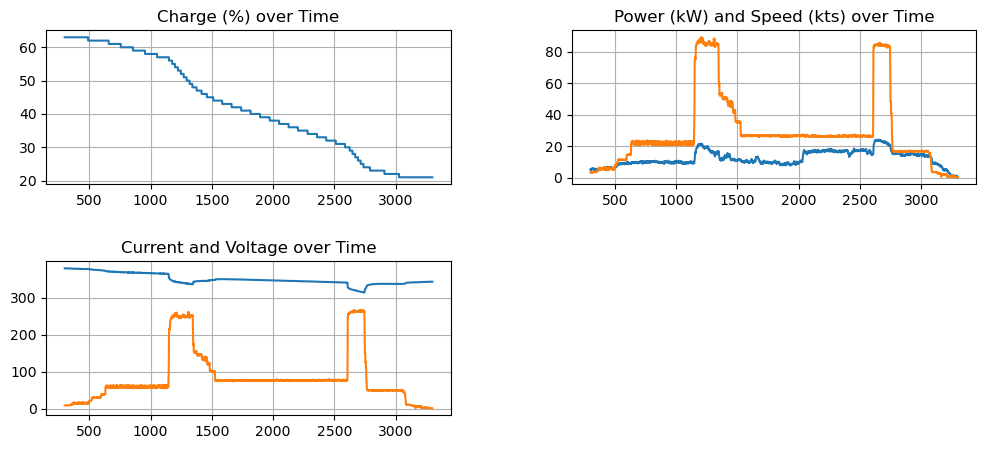

In [7]:
"""Pick a run and show overview of interesting data"""
run = 31
df = data['Run %i' % run]
print(data_files.file_summary.iloc[run-1])  # print snapshot of run

'''Summary Plots'''
plt.figure(figsize=(12,5))

plt.subplot(2,2,1)
plt.plot(df.index, df['SOC 1 %'])
plt.grid()
plt.title('Charge (%) over Time')

plt.subplot(2,2,2)
plt.plot(df.index, df['Speed kts'], df['Power 1 kW'])
plt.grid()
plt.title('Power (kW) and Speed (kts) over Time')

plt.subplot(2,2,3)
plt.plot(df.index, df['Pack Voltage 1 V'], df['Pack Current 1 A'])
plt.grid()
plt.title('Current and Voltage over Time')

# plt.subplot(2,2,4)
# plt.plot(df.index)
# plt.grid()
# plt.title('Empty')

plt.subplots_adjust(hspace = 0.5)
plt.subplots_adjust(wspace = 0.3)

### Define Algorithms

In [8]:
def overall_avg(initial_data, current_data, batt_cap):
    """This function is based on an overall average of all the data in the trip.
    Takes in a dataframe from the vessel and the capacity of the battery."""

    # dist_list = []

    # for i in range(len(data)):
    #     batt = data['SOC 1 %%'].iloc[i]*batt_cap/100
    #     avg_batt_consumed = (data['SOC 1 %'].iloc[0] - data['SOC 1 %'].iloc[i])*batt_cap/100          #kWh
    #     avg_dist_traveled = (data['Distance nm'].iloc[i] - data['Distance nm'].iloc[0])               #nm

    batt = current_data['SOC 1 %']*batt_cap/100
    total_batt_consumed = (initial_data['SOC 1 %'] - current_data['SOC 1 %'])*batt_cap/100
    total_dist_traveled = current_data['Distance nm'] - initial_data['Distance nm']
    total_time_traveled = current_data['Time'] - initial_data['Time']

    # avg_consumption = total_batt_consumed/total_dist_traveled             #kWh/nm
    # dist_remaining = batt/avg_consumption                                 #nm

    avg_consumption = total_batt_consumed/(total_time_traveled.seconds/3600)       #kWh/hr
    time_remaining = batt/avg_consumption                                   #hr
    dist_remaining = time_remaining*current_data['Speed kts']               #nm
    

        # dist_list.append(dist_remaining)

    return dist_remaining



def rolling_avg(data, batt_cap, N):
    """This function is based on a rolling average consumption rate of N data points.
    Any consumption rates that are not valid, or within the first N data points of the run,
    will default to using the stored average consumption rate."""

    dist_list = []

    cached_avg = data_files.file_summary.iloc[run-1]['Average Consumption (kWh/nm)']       # need a cached average value to default to 
    for i in range(len(data)):
        batt = data['SOC 1 %'].iloc[i]*batt_cap/100
        roll_batt_consumed = (data['SOC 1 %'].iloc[i-N] - data['SOC 1 %'].iloc[i])*batt_cap/100          #kWh
        roll_dist_traveled = (data['Distance nm'].iloc[i] - data['Distance nm'].iloc[i-N])                  #nm
        roll_consumption = roll_batt_consumed/roll_dist_traveled                                            #kWh/nm
        
        if i < N or roll_consumption==0:
            dist_remaining = batt/cached_avg      # This will need to change because we won't know the average with real-time data
            print('%d Batt: %.1f | Consumption Rate: %.2f kWh/nm | Dist Remaining %.1f nm' % (i, batt, cached_avg, dist_remaining), end=' \r')
            # time.sleep(0.001)
        else:
            dist_remaining = batt/roll_consumption   #nm
            print('%d Batt: %.1f | Consumption Rate: %.2f kWh/nm | Dist Remaining: %.2f nm' % (i, batt, roll_consumption, dist_remaining), end=' \r')
            # time.sleep(.001)

        dist_list.append(dist_remaining)

    return dist_list



def update_average():
    """This is a function to update the stored average consumption of the vessel."""

    pass


# Testing by Class Imports

In [ ]:
from testing_class import testing
from algorithm_class import Range_est

run = 31
df = data['Run %i' % run]
df['tripDistance'] = ''
df['energyUsed'] = ''
df['tripDuration'] = ''
df['range'] = ''

def add_new_variables(df):

    for i in range(len(df)):
        df['tripDistance'].iloc[i] = df['Distance km'].iloc[i] - df['Distance km'].iloc[0]
        df['energyUsed'].iloc[i] = (df['SOC 1 %'].iloc[0] - df['SOC 1 %'].iloc[i])*63/100
        df['tripDuration'].iloc[i] = (df['Time'].iloc[i] - df['Time'].iloc[0]).seconds/60
    return df

df = add_new_variables(df)


"""Test Loop"""
for i in range(len(df)):
    dataStream = testing().parse_csv(df.iloc[i])

    # range_remaining = Range_est.overall_avg()

    range_remaining = overall_avg(df.iloc[0], df.iloc[i], 63)
    df['range'].iloc[i] = range_remaining


df.head()


### Overall Avg Testing Loop

/tmp/ipykernel_675/3359315373.py:20: RuntimeWarning: invalid value encountered in double_scalars
  avg_consumption = total_batt_consumed/(total_time_traveled.seconds/3600)       #kWh/hr
/tmp/ipykernel_675/3359315373.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  time_remaining = batt/avg_consumption                                   #hr


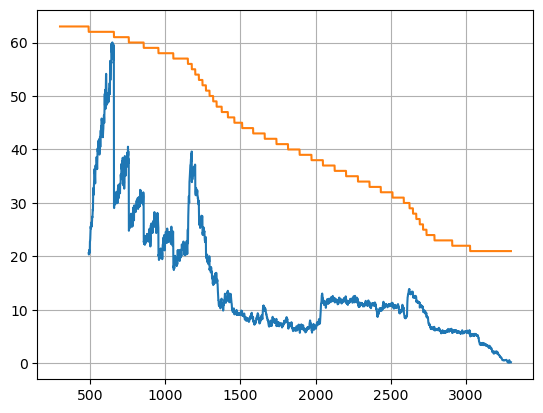

In [14]:
"""
Testing Loop:
    -Loop through CSV rows and update estimated mileage on each iteration
    -Call functions within test loop
"""
dist_list = []
for i in range(len(df)):
    current_data = df.iloc[i]
    initial_data = df.iloc[0]
    
    dist_remaining = overall_avg(initial_data, current_data, 58)
    print('%d Batt: %.1f | Dist Remaining: %.2f nm' % (i, current_data['SOC 1 %'], dist_remaining), end=' \r')
    # time.sleep(.001)

    dist_list.append(dist_remaining)

plt.plot(df.index, dist_list, df['SOC 1 %'])
plt.grid()


# Accuracy Comparison

In [17]:
'''Look at how far the vessel traveled 30s later'''

df['Dist Prediction (nm)'] = dist_list
df['Interval Dist'] = ''
df['Interval Pred'] = ''
df['error'] = ''

interval = 30 #seconds
# for i in range(interval, len(df)):
#     interval_dist = df['Distance nm'].iloc[i] - df['Distance nm'].iloc[i-interval]
#     # interval_pred = df['Dist Prediction (nm)'].iloc[i-interval] - df['Dist Prediction (nm)'][i]
#     df['Interval Dist'].iloc[i] = interval_dist
#     # df['Interval Pred'].iloc[i] = interval_pred

dist_500 = df['Distance nm'].iloc[-1] - df['Distance nm'].iloc[500] # Distance traveled from i=500 on
pred_500 = df['Dist Prediction (nm)'].iloc[500] - df['Dist Prediction (nm)'].iloc[-1] 
print(pred_500, dist_500)

28.43564234274 4.7574342371050005


/tmp/ipykernel_675/146341163.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Dist Prediction (nm)'] = dist_list
/tmp/ipykernel_675/146341163.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Interval Dist'] = ''
/tmp/ipykernel_675/146341163.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

,Date,Time,Lat,Lon,Speed m/s,Distance km,RPM 1,Motor Load 1 %,Motor Torque 1 %,Motor Temp 1 C,...,Pack Voltage 1 V,Pack Temp 1 C,SOC 1 %,Power 1 kW,Speed kts,Distance nm,Dist Prediction (nm),Interval Dist,Interval Pred,error
300,23-04-14,1900-01-01 14:37:48,45.476379,-122.661888,2.740820,0.18290,759,1,10,28.290001,...,380.09998,15.0,63,3.53493,5.328154,0.098758,NaN,,,
301,23-04-14,1900-01-01 14:37:49,45.476368,-122.661888,2.818574,0.18433,760,1,10,28.200001,...,380.20000,15.0,63,3.53586,5.479308,0.099530,inf,,,
302,23-04-14,1900-01-01 14:37:50,45.476353,-122.661888,2.779697,0.18577,760,1,10,28.290001,...,380.20000,15.0,63,3.53586,5.403731,0.100308,inf,,,
303,23-04-14,1900-01-01 14:37:51,45.476452,-122.661888,2.682505,0.18717,760,1,10,28.290001,...,380.20000,15.0,63,3.42180,5.214790,0.101064,inf,,,
304,23-04-14,1900-01-01 14:37:52,45.476440,-122.661888,2.740820,0.18858,760,1,10,28.290001,...,380.09998,15.0,63,3.45891,5.328154,0.101825,inf,,,
